In [1]:
#read file
crop_name='wheat'
directory=f'K:/ecole/github/televerser/civ6/misc/crops/yield/{crop_name}_HarvAreaYield_Geotiff'

#import packages
#to install gdal is painful
#the recommendation is to pip install whl files
#download file with respect to ur python version
#cp36 refers to python 3.6
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
os.chdir(directory)

In [2]:
#read geotiff
ds=gdal.Open(f'{crop_name}_Production.tif')

#get data
data=ds.GetRasterBand(1).ReadAsArray()

#GDAL affine transform parameters
#according to gdal documentation xoff/yoff are image left corner
#a/e are pixel wight/height and b/d is rotation and is zero if image is north up
# https://scriptndebug.wordpress.com/2014/11/24/latitudelongitude-of-each-pixel-using-python-and-gdal/
xoff,a,b,yoff,d,e=ds.GetGeoTransform()

# #get coordinates
# lons=[a*col+b*row+xoff for row in range(data.shape[0]) for col in range(data.shape[1])]
# lats=[d*col+e*row+yoff for row in range(data.shape[0]) for col in range(data.shape[1])]

#matrix inner product to boost execution speed
lon_prod=np.array([[b],[a]])
lat_prod=np.array([[e],[d]])
coors=np.array(np.where(~np.isnan(data))).T
lons=coors@lon_prod+xoff
lats=coors@lat_prod+yoff

In [3]:
#create dataframe
df=pd.DataFrame()
df['lon']=lons
df['lat']=lats
df['value']=data.flatten()
df.dropna(inplace=True)

#only get significant value
export=df[df['value']>np.percentile(df['value'],95)]

#log scale
export['value']=np.log(export['value'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


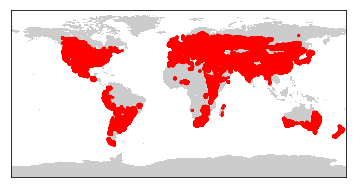

In [4]:
#viz
m=Basemap()
m.drawlsmask()
x,y=m(export['lon'],export['lat'])
plt.scatter(x,y,color='red',s=(export['value']))
plt.show()

In [5]:
#save data
export.to_csv(f'{crop_name}.csv',index=False)